In [29]:
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, './orchard')

from orchard.find_missing_trees import *
from orchard.aerobotics_requests import *

In [30]:
orchard_id = 216269

### Step 1: Get the orchard details and the coordinates of trees from the latest survey

In [31]:
# Details of orchard; for polygon 
single_orchard_response = fetch_single_orchard(orchard_id)

# Get teh details of all surveys for current orchard
survey_response = fetch_all_orchard_surveys(orchard_id)
surveys = survey_response.json()["results"]  # TODO: Need to handle pagination
surveys_sorted_by_date = sorted(surveys, key=lambda survey: survey["date"])
latest_survey_id = surveys_sorted_by_date[-1]["id"]

# Get the trees for the latest survey
tree_surveys_response = fetch_single_survey(latest_survey_id)
tree_surveys = tree_surveys_response.json()

In [32]:
# ### Single Call
# m = findMissingTrees(orchard_response_json=single_orchard_response.json(), survey_response_json=tree_surveys_response.json())
# m

[{'lat': -32.32890469467948, 'lng': 18.825865655754654},
 {'lat': -32.32880084663632, 'lng': 18.826435883251875},
 {'lat': -32.32868098269371, 'lng': 18.826676939956673},
 {'lat': -32.32862520358892, 'lng': 18.825669547116767}]

### Step 2: Store polygon data and tree data in two DataFrames

In [43]:
polygon_latlongs = single_orchard_response.json()["polygon"]

polygon_lng_data = [] # list of polygon lng coords
polygon_lat_data = [] # list of polygon lat coords
for l in polygon_latlongs.split(" "):
    l_split = l.split(",")
    polygon_lng_data.append(float(l_split[0]))
    polygon_lat_data.append(float(l_split[1]))
polygon_n_points = len(polygon_lat_data) # n points in polygon

polygon_df = pd.DataFrame({"lng": polygon_lng_data, "lat": polygon_lat_data})

trees_df = pd.DataFrame(tree_surveys["results"])

#### Remove trees randomly as a check

In [44]:
# Remove rows randomly from trees_df
# n = 5
# rows_to_remove = trees_df.sample(n=n).index
# trees_df = trees_df.drop(rows_to_remove)

# Or remove percentage of dataset:
isRemoveRandom = True
if (isRemoveRandom):
    frac = 0.05
    rows_to_remove = trees_df.sample(frac=frac).index
    trees_df = trees_df.drop(rows_to_remove)

#### Current Orchard with Missing Trees

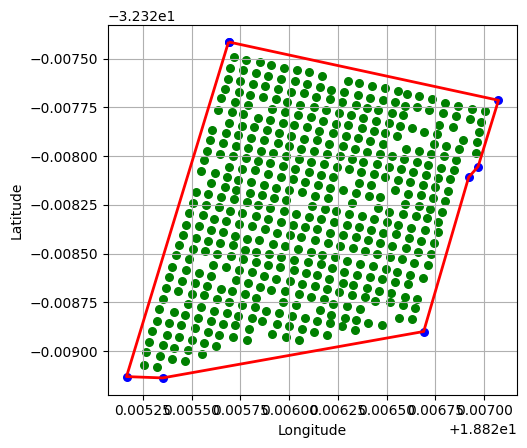

In [45]:
# Points for plotting corners
polygon_points = [Point(xy) for xy in zip(polygon_df['lng'], polygon_df['lat'])]
polygon_points_gdf = gpd.GeoDataFrame(polygon_df, geometry=polygon_points)

# Polygon shape from points
polygon_geometry = Polygon(polygon_points)
polygon_geometry_gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon_geometry])

# Points for Trees
tree_points = [Point(xy) for xy in zip(trees_df['lng'], trees_df['lat'])]
tree_points_gdf = gpd.GeoDataFrame(trees_df, geometry=tree_points)

# Plot points
ax = polygon_points_gdf.plot(marker='o', color='blue', markersize=30, label="Polygon Corners")
# Plot polygon on same axis as points
polygon_geometry_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label="Polygon Sides")
# Plot trees
tree_points_gdf.plot(ax=ax, marker='o', color='green', markersize=30, label="Trees")

# Bounding Box of polygon
poly_min_x, poly_min_y, poly_max_x, poly_max_y = polygon_geometry.bounds


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

plt.show()

### Step 3: Cluster Trees the Two Directions

In [46]:
x = np.array(trees_df['lng'])
y = np.array(trees_df['lat'])

# Find slopes of both directions
slopes = findOrchardSlopes(x,y)

dir_1_slope = slopes[0]
dir_2_slope = slopes[1]

# Clusters according to slope
# Get the y-intercept of a cluster for the current direction and the labels
dir_1_y_intercepts, dir_1_labels = clusterTreesBySlope(x,y,slopes[0])
dir_2_y_intercepts, dir_2_labels = clusterTreesBySlope(x,y,slopes[1])   

# Add the labels to the trees dataframe
trees_df["dir_1_labels"] = dir_1_labels
trees_df["dir_2_labels"] = dir_2_labels

# Print clustering results
print("Direction 1 slope: ", dir_1_slope)
print("Direction 2 slope: ", dir_2_slope)
print("Clusters for Direction 1: ", len(dir_1_y_intercepts))
print("Clusters for Direction 2: ", len(dir_2_y_intercepts))

Direction 1 slope:  3.726398816893843
Direction 2 slope:  -0.2316393238131418
Clusters for Direction 1:  21
Clusters for Direction 2:  30


#### Plot Direction Clusters

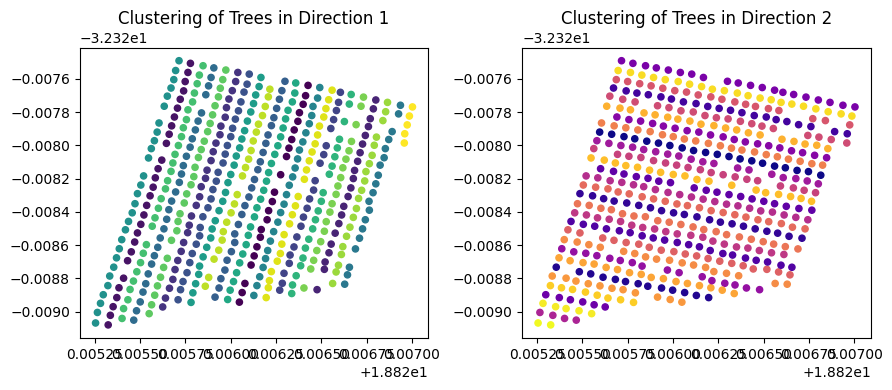

In [47]:
# Plot the clustering
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Dir 1 plot
scatter_1 = axes[0].scatter(x, y, c=dir_1_labels, cmap='viridis', s=20)
axes[0].set_title("Clustering of Trees in Direction 1")
# Dir 2 plot
scatter_2 = axes[1].scatter(x, y, c=dir_2_labels, cmap='plasma', s=20)
axes[1].set_title("Clustering of Trees in Direction 2")

plt.tight_layout()
plt.show()

### Step 4: Create LineString Grid, Find Outlier Distances, Map Tree Gaps to Grid

#### Geometry LineStrings in the current direction

In [48]:
# Geometry linestrings in the directions
dir_1_linestrings = geometryLineStringsFromIntercepts(dir_1_y_intercepts, dir_1_slope, poly_min_x, poly_max_x, poly_min_y, poly_max_y)
dir_2_linestrings = geometryLineStringsFromIntercepts(dir_2_y_intercepts, dir_2_slope, poly_min_x, poly_max_x, poly_min_y, poly_max_y)


#### Calculte the distance between adjacent trees and find outliers

In [49]:

# Calculate the distances between adjacent trees in a clustered direction
dir_1_distances, dir_1_distances_dict = distanceBetweenAdjacentTrees(trees_df, len(dir_1_y_intercepts), 'dir_1_labels')
dir_2_distances, dir_2_distances_dict = distanceBetweenAdjacentTrees(trees_df, len(dir_2_y_intercepts), 'dir_2_labels')

# Get the outlier distances; tree_from and tree_to
dir_1_outliers = outlierDistances(dir_1_distances, dir_1_distances_dict)
dir_2_outliers = outlierDistances(dir_2_distances, dir_2_distances_dict)

print("Direction 1 Outliers: ")
print(dir_1_outliers)
print("Direction 2 Outliers: ")
print(dir_2_outliers)


Direction 1 Outliers: 
[(np.int32(0), np.int64(54733260), np.int64(54733423), 12.528544408541578), (np.int32(0), np.int64(54733423), np.int64(54733399), 12.097161088893436), (np.int32(0), np.int64(54733118), np.int64(54733053), 12.716177298353818), (np.int32(1), np.int64(54733302), np.int64(54733322), 11.443760545900375), (np.int32(1), np.int64(54733149), np.int64(54733071), 11.860937731701469), (np.int32(2), np.int64(54733106), np.int64(54733002), 14.091111787631315), (np.int32(4), np.int64(54733245), np.int64(54733269), 11.7583853794757), (np.int32(4), np.int64(54733272), np.int64(54733175), 11.943700815266899), (np.int32(7), np.int64(54733384), np.int64(54733379), 12.3477794429872), (np.int32(8), np.int64(54733327), np.int64(54733235), 12.297855805401756), (np.int32(8), np.int64(54732970), np.int64(54733025), 12.648392454248075), (np.int32(10), np.int64(54733394), np.int64(54733397), 11.51295952643157), (np.int32(10), np.int64(54733324), np.int64(54733224), 12.268848158003442), (np.

#### Map outliers to grid and find intersection points between them

In [50]:
dir_1_missing_points = findIntersectionsBetweenTrees(trees_df, dir_1_outliers, dir_1_linestrings, dir_2_linestrings)
dir_2_missing_points = findIntersectionsBetweenTrees(trees_df, dir_2_outliers, dir_2_linestrings, dir_1_linestrings)

print(dir_1_missing_points)
print(dir_2_missing_points)

[<POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.825 -32.329)>, <POINT (18.827 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>]
[<POINT (18.825 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18

#### Remove any duplicate points

In [51]:
# Remove Duplicate Points
missing_points_combined =  list(set(dir_1_missing_points + dir_2_missing_points))
print(len(missing_points_combined))
print(missing_points_combined)

27
[<POINT (18.826 -32.329)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.825 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>]


#### Output Result

In [52]:
# Missing trees to dict output format
missing_trees = []
for point in missing_points_combined:
    missing_trees.append({"lat": point.y, "lng": point.x})

missing_trees

[{'lat': -32.32862459304181, 'lng': 18.8256716799209},
 {'lat': -32.32868286723106, 'lng': 18.826678251760633},
 {'lat': -32.32773670641255, 'lng': 18.82583904677574},
 {'lat': -32.32816635787721, 'lng': 18.82647414501835},
 {'lat': -32.32853625674754, 'lng': 18.82555841343008},
 {'lat': -32.327870350969164, 'lng': 18.82689629505171},
 {'lat': -32.32781001350051, 'lng': 18.826635814803108},
 {'lat': -32.32811712880143, 'lng': 18.82552969723289},
 {'lat': -32.32874581676462, 'lng': 18.825433647729305},
 {'lat': -32.32779838538457, 'lng': 18.825615233814595},
 {'lat': -32.328259107883994, 'lng': 18.826383607486143},
 {'lat': -32.32782494054674, 'lng': 18.826700255701937},
 {'lat': -32.3282330028128, 'lng': 18.826522303251323},
 {'lat': -32.328025597448324, 'lng': 18.82562692261793},
 {'lat': -32.328802109167476, 'lng': 18.826438027027883},
 {'lat': -32.32792968516148, 'lng': 18.82667214689773},
 {'lat': -32.3281226315655, 'lng': 18.826285376069322},
 {'lat': -32.328785999350686, 'lng': 1

#### Plot of missing trees

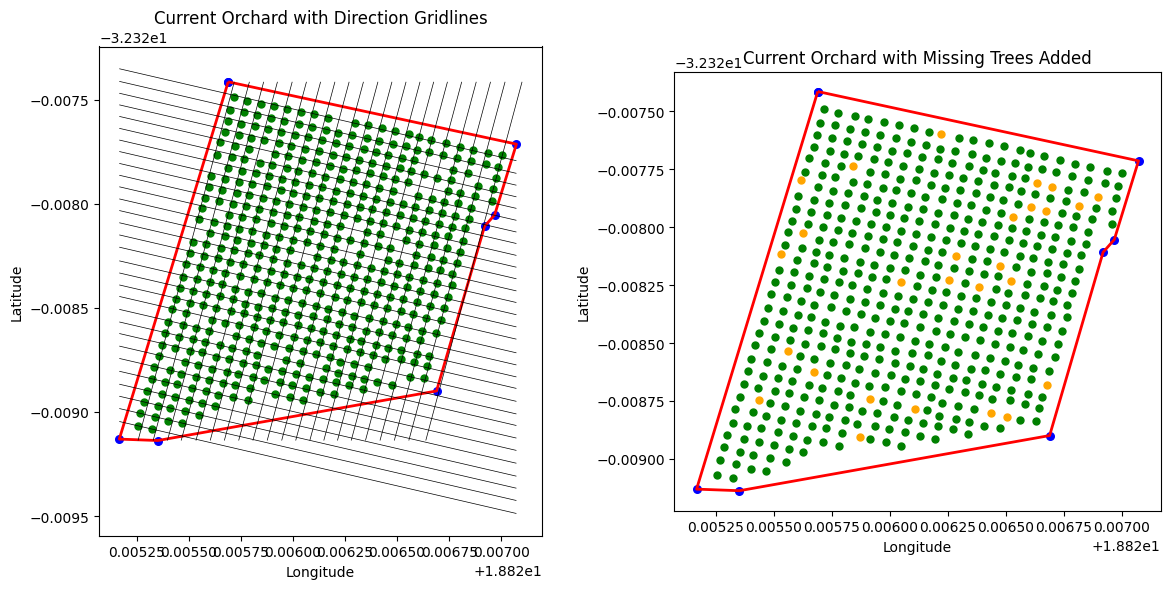

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot polygon corners
polygon_points_gdf.plot(ax=axes[0], marker='o', color='blue', markersize=30, label="Polygon Corners")
polygon_points_gdf.plot(ax=axes[1], marker='o', color='blue', markersize=30, label="Polygon Corners")
# Plot polygon sides
polygon_geometry_gdf.boundary.plot(ax=axes[0], color='red', linewidth=2, label="Polygon Sides")
polygon_geometry_gdf.boundary.plot(ax=axes[1], color='red', linewidth=2, label="Polygon Sides")


# Plot trees with gridlines on axes[0]
tree_points_gdf.plot(ax=axes[0], marker='o', color='green', markersize=25, label="Trees")
# Line Geometry for Grid
dir_1_geom_df = gpd.GeoDataFrame(geometry=dir_1_linestrings)
dir_1_geom_df.plot(ax=axes[0], color='black', linewidth=0.5)

dir_2_geom_df = gpd.GeoDataFrame(geometry=dir_2_linestrings)
dir_2_geom_df.plot(ax=axes[0], color='black', linewidth=0.5)

axes[0].set_title("Current Orchard with Direction Gridlines")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")


# Plot trees with missing trees on axes[1]
tree_points_gdf.plot(ax=axes[1], marker='o', color='green', markersize=25, label="Trees")
# Missing Trees
missing_points_combined_gdf = gpd.GeoDataFrame(geometry=missing_points_combined)
missing_points_combined_gdf.plot(ax=axes[1], marker='o', color='orange', markersize=25)

axes[1].set_title("Current Orchard with Missing Trees Added")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")


plt.tight_layout()
plt.show()